## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mtp
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## Reading & Exploring Data

In [2]:
df = pd.read_csv('machine.data',header=None)
cols = ['vendor','model','myct','mmin','mmax','cach','chmin','chmax','prp','erp']
df.columns = cols
df.head(2)

,vendor,model,myct,mmin,mmax,cach,chmin,chmax,prp,erp
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253


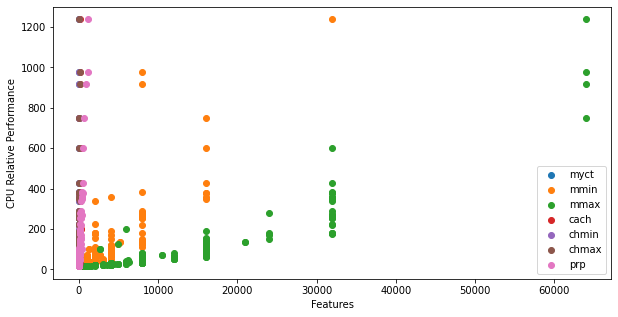

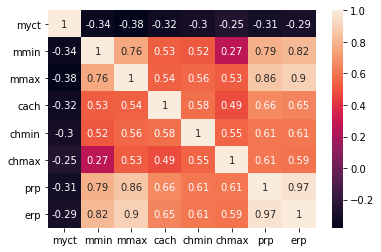

In [3]:
plt.figure(figsize=(10,5))
target = 'erp'
features = cols[2:9]
for feature in features:
    plt.scatter(x=df[feature],y=df[target],label=feature,marker='o')
plt.xlabel("Features")
plt.ylabel("CPU Relative Performance")
plt.legend()
plt.show()
sns.heatmap(data=df.corr(),annot=True)
plt.show()

## Separating Training & Test Data

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df[features],df[target],
                                    test_size=0.35,random_state=40)

## Regression with Decision Tree

In [5]:
regressor = DecisionTreeRegressor(random_state=40)
regressor.fit(x_train,y_train)


DecisionTreeRegressor(random_state=40)

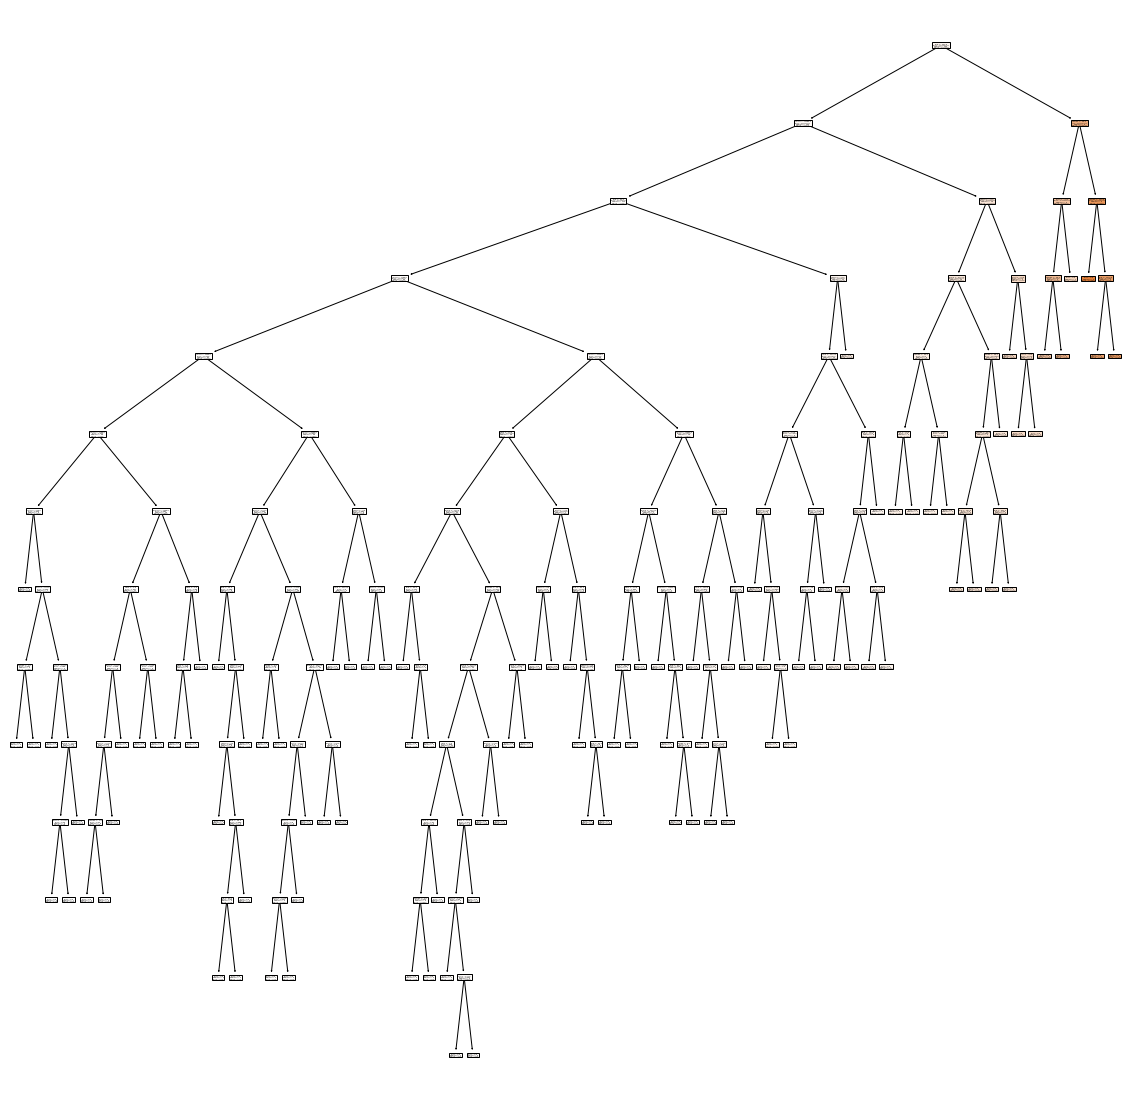

In [6]:
# To Plot the Tree

plt.figure(figsize=(20,20))
tree.plot_tree(regressor,feature_names=features,class_names='erp',filled=True);
plt.show()

In [7]:
results = regressor.predict(x_test)
regressor.score(x_test,y_test)

0.8777172726030066

## Model Accuracy

In [8]:
# using mse and its square-root
mse = mean_squared_error(y_test,results)
np.sqrt(mse)

29.227208722861814

In [9]:
# using absolute errors and mean absolute errors
absolute_errors = abs(results-y_test) #returns the array of errors
avg_abs_error = round(np.mean(absolute_errors))
avg_abs_error

15

In [10]:
# percentage of error using absolute errors
error_percentage = (absolute_errors/y_test) * 100
avg_error_percentage = np.mean(error_percentage)
print("Accuracy : " , round(100-avg_error_percentage), "%")

Accuracy :  85 %


## Features Importances

In [11]:
importances = regressor.feature_importances_
for index in range(len(importances)):
    print(features[index], ":",round(importances[index],3))

myct : 0.011
mmin : 0.006
mmax : 0.153
cach : 0.001
chmin : 0.014
chmax : 0.084
prp : 0.731


## Pruning Tree

In [12]:
# this block stores alphas & impurities from ccp_paths
# also, we store trees tht correspond to those alphas and impurities

ccp_paths = regressor.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = ccp_paths.ccp_alphas, ccp_paths.impurities
ccp_alphas = ccp_alphas[:-1]  #so it doesn't prune everything till root
impurities = impurities[:-1]
trees = []

for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(ccp_alpha=alpha,random_state=40)
    dt.fit(x_train,y_train)
    trees.append(dt)


## Finding Alpha taking in consideration all factors

In [13]:
scores = []
for dt in trees:
    scores.append(dt.score(x_test,y_test))

tree_depths = [clf.tree_.max_depth for clf in trees]

# for i in range(len(scores)):
#     print("Impurity:",impurities[i],"Alpha:",ccp_alphas[i],"Score:",scores[i],"Depth:",tree_depths[i])
ccp_alphas[scores.index(max(scores))]


1.2892592592592471

In [14]:
pruned_regressor = DecisionTreeRegressor(ccp_alpha=1.28,random_state=10)
pruned_regressor.fit(x_train,y_train)
pruned_results = pruned_regressor.predict(x_test)
pruned_regressor.score(x_test,y_test)

0.8718210070072874

## Plotting Predictions vs Pruned vs Actual 

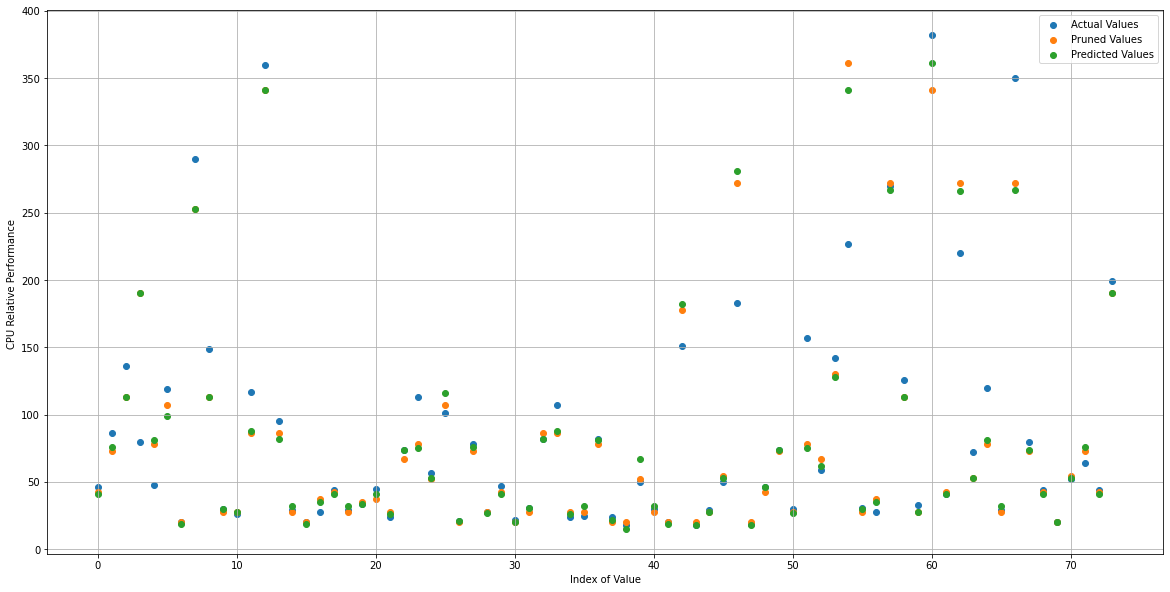

In [15]:
indexes = []   # this is as a dummy x-axis
for i in range(len(y_test)):
    indexes.append(i)
plt.figure(figsize=(20,10))
plt.scatter(indexes,y_test,label="Actual Values")
plt.scatter(indexes,pruned_results,label="Pruned Values")
plt.scatter(indexes,results,label="Predicted Values")
plt.xlabel("Index of Value")
plt.ylabel("CPU Relative Performance ")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
pruned_regressor.get_depth(),regressor.get_depth()

(8, 13)

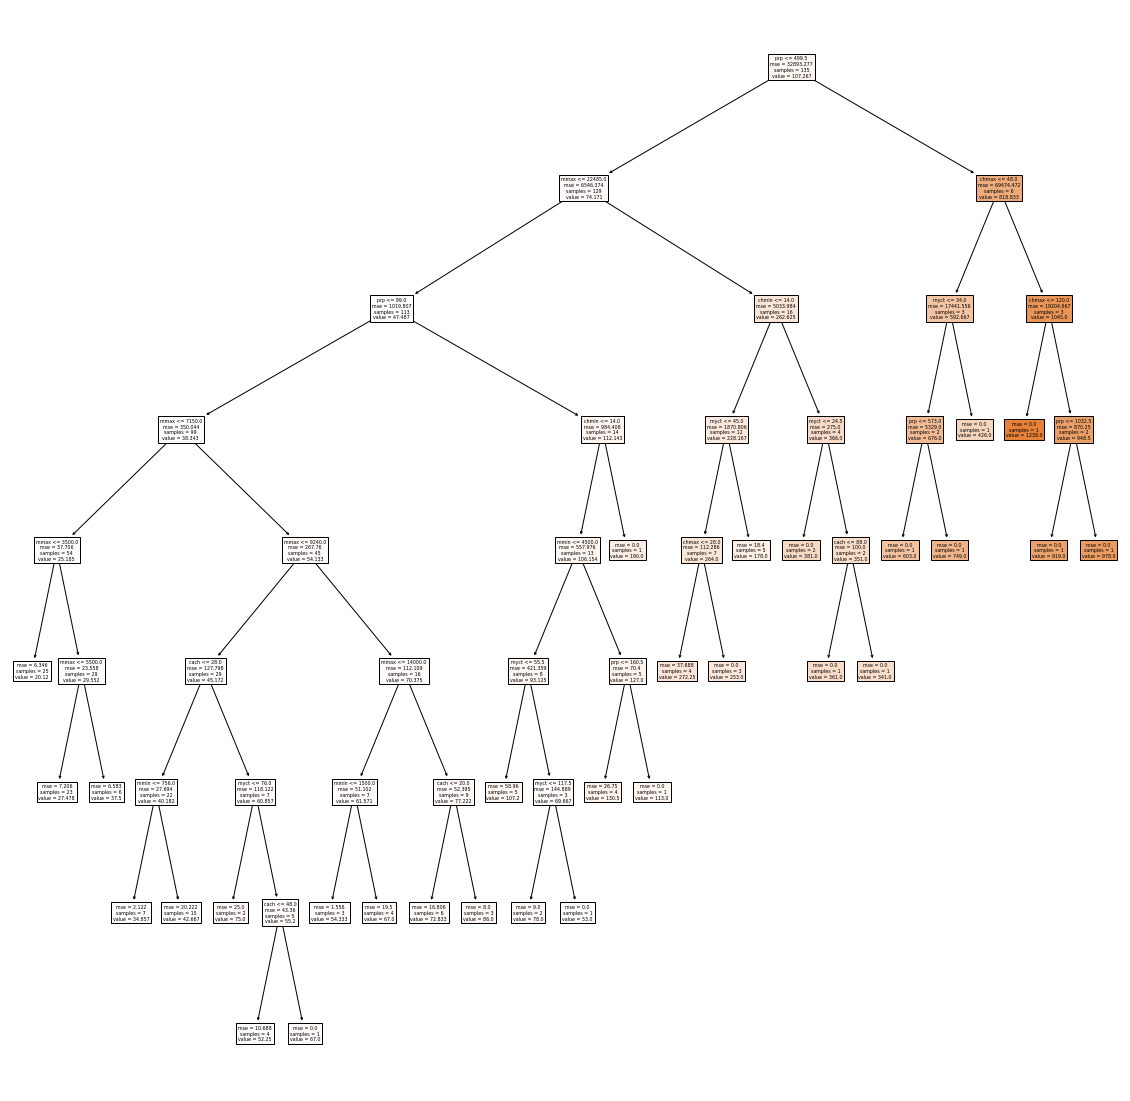

In [17]:
# To Plot the Pruned Tree

plt.figure(figsize=(20,20))
tree.plot_tree(pruned_regressor,feature_names=features,class_names='erp',filled=True);
plt.show()

## Model Accuracy

In [18]:
# using mse and its square-root
mse = mean_squared_error(y_test,pruned_results)
np.sqrt(mse)

29.92355656720132

In [19]:
# using absolute errors and mean absolute errors
absolute_errors = abs(pruned_results-y_test) #returns the array of errors
avg_abs_error = round(np.mean(absolute_errors))
avg_abs_error

15

In [20]:
# percentage of error using absolute errors
error_percentage = (absolute_errors/y_test) * 100
avg_error_percentage = np.mean(error_percentage)
print("Accuracy : " , round(100-avg_error_percentage), "%")

Accuracy :  85 %


## Features Importances

In [21]:
importances = pruned_regressor.feature_importances_
for index in range(len(importances)):
    print(features[index], ":",round(importances[index],3))

myct : 0.015
mmin : 0.001
mmax : 0.153
cach : 0.001
chmin : 0.014
chmax : 0.082
prp : 0.734


## Conclusion
Here it is not making very much difference when it comes to results (accuracy) but depth of pruned is nearly half. The features weight have changed too. Pruned predictions are nearly same as unpruned(as shown in the figure above)